In [1]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
from torch import nn
import torch.optim as optim 
import torchvision
from torchvision import transforms, models, datasets
import imageio
import time 
import warnings
import random
import sys
import copy
import json
from PIL import Image

data_dir = './raw_data'
train_dir = data_dir + './train'
valid_dir = data_dir + './valid'

In [2]:
data_transforms = {
            # -45~45度之间，随机旋转一个角度
    'train' : transforms.Compose([transforms.RandomRotation(45),
            # 从中心开始裁剪
            transforms.CenterCrop(244),
            # 随机水平翻转，选择一个概率
            transforms.RandomHorizontalFlip(p = 0.5),
            # 随机垂直翻转，选择一个概率
            transforms.RandomVerticalFlip(p = 0.5),
            # 参数1为亮度，参数2为对比度，参数3为饱和度，参数4为色相
            transforms.ColorJitter(brightness = 0.2, contrast = 0.1, saturation = 0.1, hue = 0.1),
            # 概率转换为灰度率，3通道就是R=G=B
            transforms.RandomGrayscale(p = 0.025),
            # 上述数据转换为Tensor数据
            transforms.ToTensor(),
            # 模型设定好的均值和标准差
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
            # 一般拿到图像先做Resize()，然后再裁剪，因为这个训练集数据比较小，所以没做
    'valid' : transforms.Compose([transforms.Resize(256),
            transforms.CenterCrop(244),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # 如果有test再多写一个test
}

In [3]:
batch_size = 8
# ImageFolder(数据的实际路径, 预处理的流程)
image_datasets = {x : datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid']}
# 用utlis中的DataLoader将构建好的数据集train和valid遍历传进去
dataloaders = {x : torch.utils.data.DataLoader(image_datasets[x], batch_size = batch_size, shuffle = True) for x in ['train', 'valid']}
dataset_size = {x : len(image_datasets[x])for x in ['train', 'valid']}
class_names = image_datasets['train'].classes


In [4]:
def im_convert(tensor):
    
    image = tensor.to('cpu').clone().detach()
    image = image.numpy().squeeze()
    # 正常情况下的数据是H*W*C，但在torch中颜色通道在第一个(CHW)，因此执行transpose将CHW还原为HWC
    image = image.transpose(1,2,0)    
    # 在数据预处理中对数据进行了标准化，也要还原
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    
    return image

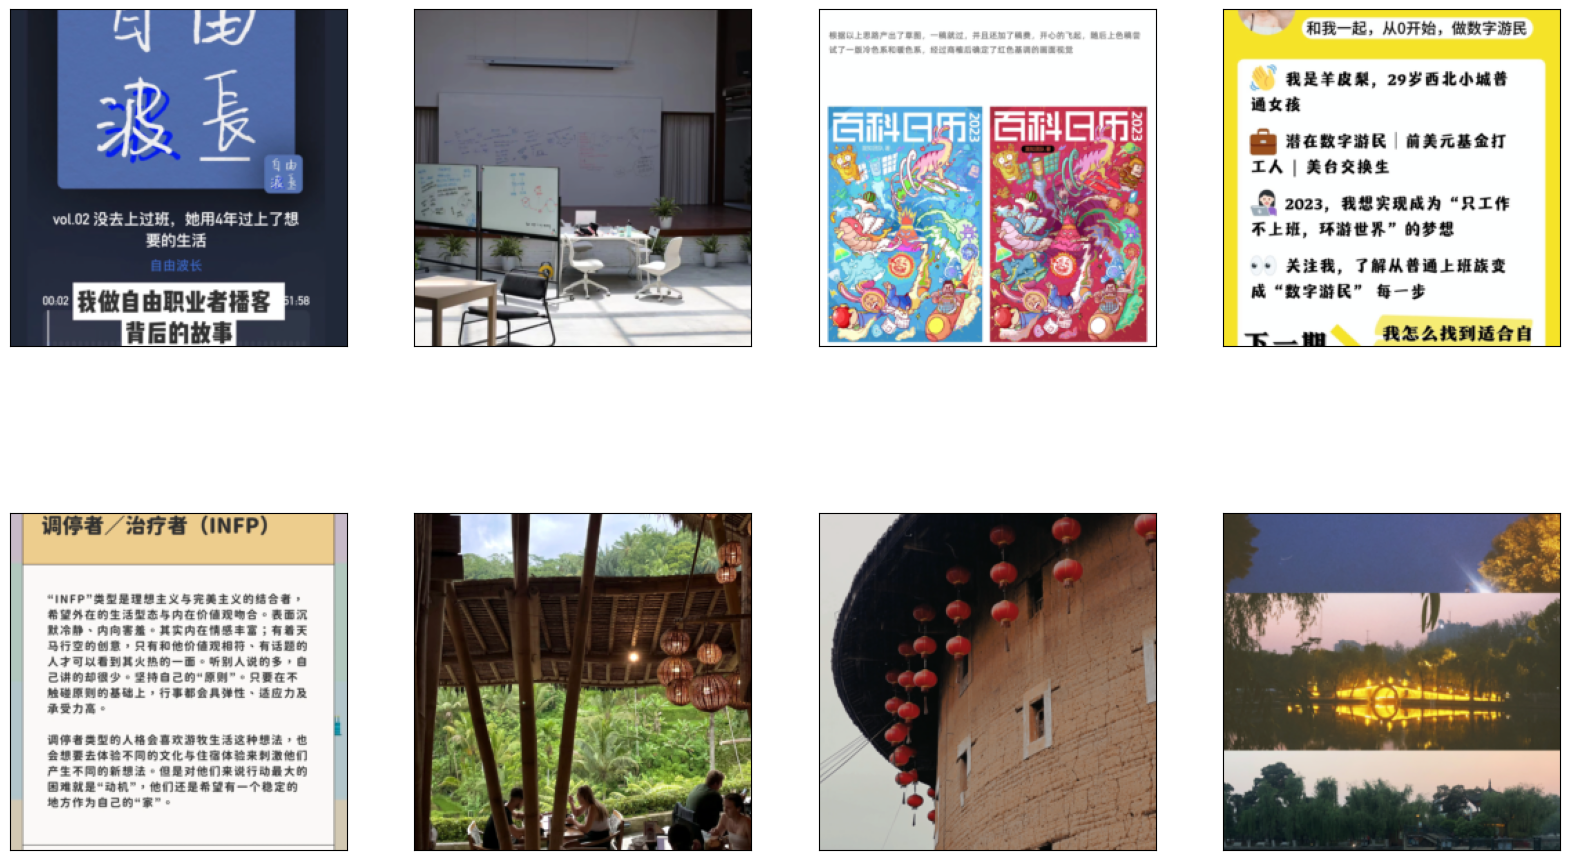

In [5]:
fig = plt.figure(figsize = (20, 12))
columns = 4
rows = 2

dataiter = iter(dataloaders['valid'])
inputs, classes = dataiter.__next__()

for idx in range(columns * rows):
    ax = fig.add_subplot(rows, columns, idx+1, xticks = [], yticks = [])
#     ax.set_title(cat_to_name[str(int(class_names[classes[idx]]))])
    plt.imshow(im_convert(inputs[idx]))
plt.show()

In [6]:
model_name = 'resnet'
# 是否用经典模型中训练好的参数来做
feature_extract = True
device = torch.device("cuda")

In [7]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():            
            # 屏蔽预训练模型的权重,只训练全连接层的权重
            param.requires_grad = False

In [8]:
model_ft = models.resnet18() #18层的resnet网络

In [9]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # 初始化将在此if语句中设置的这些变量。 
    # 每个变量都是模型特定的。
    model_ft = None
    input_size = 0
 
    if model_name == "resnet":
        """ Resnet18
 """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
#         model_ft.fc = nn.Linear(num_ftrs, num_classes)
        model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, 2), nn.LogSoftmax(dim = 1))
        input_size = 224
 
    elif model_name == "alexnet":
        """ Alexnet
 """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224
 
    elif model_name == "vgg":
        """ VGG11_bn
 """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224
 
    elif model_name == "squeezenet":
        """ Squeezenet
 """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224
 
    elif model_name == "densenet":
        """ Densenet
 """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224
 
    elif model_name == "inception":
        """ Inception v3
 Be careful, expects (299,299) sized images and has auxiliary output
 """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # 处理辅助网络
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # 处理主要网络
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299
 
    else:
        print("Invalid model name, exiting...")
        exit()
 
    return model_ft, input_size



In [10]:
# 初始化模型
# model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
model_ft, input_size = initialize_model(model_name, 2, feature_extract, use_pretrained=True)

# mps计算,将模型发送到mps
model_ft = model_ft.to(device)

# 模型保存
filename = 'checkpoint.pth'

# 在此运行中收集要优化/更新的参数。 
# 如果我们正在进行微调，我们将更新所有参数。 
# 但如果我们正在进行特征提取方法，我们只会更新刚刚初始化的参数，即`requires_grad`的参数为True。
# 是否训练所有层
params_to_update = model_ft.parameters()
print('params to learn:')

if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)


/root/miniconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


params to learn:
	 fc.0.weight
	 fc.0.bias


In [11]:
# 优化器设置
optimizer_ft = optim.Adam(params_to_update, lr=1e-2)
# 学习率衰减策略
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)#学习率每7个epoch衰减成原来的1/10
#最后一层已经LogSoftmax()了，所以不能nn.CrossEntropyLoss()来计算了，nn.CrossEntropyLoss()相当于logSoftmax()和nn.NLLLoss()整合
criterion = nn.NLLLoss()


In [12]:
# def train_model(用哪个模型, 每个batch怎么加载, 损失函数, 优化器, 训练的epoch数=25, is_inception=False,filename=filename)
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False,filename=filename):
    since = time.time()
    
    # 保存一个最好的epoch准确率
    best_acc = 0
    """
    checkpoint = torch.load(filename)
    best_acc = checkpoint['best_acc']
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    model.class_to_idx = checkpoint['mapping']
    """
    # 指定mps做训练
    model.to(device) 

    val_acc_history = []
    train_acc_history = []
    train_losses = []
    valid_losses = []
    LRs = [optimizer.param_groups[0]['lr']]
    
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 训练和验证
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # 训练
            else:
                model.eval()   # 验证

            running_loss = 0.0
            running_corrects = 0

            # 把数据都取个遍
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 清零
                optimizer.zero_grad()
                # 只有训练的时候计算和更新梯度
                with torch.set_grad_enabled(phase == 'train'):
                    # 这个if没用，不会执行
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        
                        outputs.to(device)
                        aux_outputs.to(device)
                        criterion.to(device)
                        
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:#resnet执行的是这里
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                    
                    _, preds = torch.max(outputs, 1)

                    # 训练阶段更新权重
                    if phase == 'train':
                        loss.to(device) #
                        loss.backward()
                        optimizer.step()

                # 计算损失
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.type(torch.float32) / len(dataloaders[phase].dataset)
            
            
            
            time_elapsed = time.time() - since
            print('Time elapsed {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            

            # 得到最好那次的模型
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                state = {
                  'state_dict': model.state_dict(),
                  'best_acc': best_acc,
                  'optimizer' : optimizer.state_dict(),
                }
                torch.save(state, filename)
            if phase == 'valid':
                val_acc_history.append(epoch_acc)
                valid_losses.append(epoch_loss)
                scheduler.step(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_losses.append(epoch_loss)
        
        print('Optimizer learning rate : {:.7f}'.format(optimizer.param_groups[0]['lr']))
        LRs.append(optimizer.param_groups[0]['lr'])
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 训练完后用最好的一次当做模型最终的结果
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history, valid_losses, train_losses, LRs 



In [ ]:
model_ft, val_acc_history, train_acc_history, valid_losses, train_losses, LRs  = train_model(model_ft, dataloaders, criterion, optimizer_ft, num_epochs=20, is_inception=(model_name=="inception"))

Epoch 0/19
----------
Time elapsed 13m 4s
train Loss: 0.7422 Acc: 0.8220
Time elapsed 18m 11s
valid Loss: 0.2259 Acc: 0.9290
Optimizer learning rate : 0.0100000

Epoch 1/19
----------


/root/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Time elapsed 31m 14s
train Loss: 0.8131 Acc: 0.8282
Time elapsed 36m 20s
valid Loss: 1.2912 Acc: 0.7913
Optimizer learning rate : 0.0100000

Epoch 2/19
----------
Time elapsed 49m 32s
train Loss: 0.8721 Acc: 0.8274
Time elapsed 54m 39s
valid Loss: 2.2050 Acc: 0.6500
Optimizer learning rate : 0.0100000

Epoch 3/19
----------
Time elapsed 67m 46s
train Loss: 0.8352 Acc: 0.8398
Time elapsed 72m 57s
valid Loss: 0.3757 Acc: 0.9201
Optimizer learning rate : 0.0100000

Epoch 4/19
----------
Time elapsed 86m 21s
train Loss: 0.7619 Acc: 0.8384
Time elapsed 91m 32s
valid Loss: 0.2244 Acc: 0.9459
Optimizer learning rate : 0.0100000

Epoch 5/19
----------
Time elapsed 104m 60s
train Loss: 0.7684 Acc: 0.8446
Time elapsed 110m 12s
valid Loss: 0.3378 Acc: 0.9300
Optimizer learning rate : 0.0100000

Epoch 6/19
----------
Time elapsed 123m 56s
train Loss: 0.7111 Acc: 0.8464
Time elapsed 129m 8s
valid Loss: 0.1930 Acc: 0.9461
Optimizer learning rate : 0.0100000

Epoch 7/19
----------
Time elapsed 142m 3

In [23]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import os
import shutil
from PIL import Image
import torch.nn as nn


# 定义设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size = 224  # 定义input_size变量

def load_model(model_path, model_class, device):
    checkpoint = torch.load(model_path)
    
    # 创建模型实例
    model = model_class(pretrained=False)  
    
    # 修改最后的全连接层以匹配类别的输出
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(nn.Linear(num_ftrs, 2), nn.LogSoftmax(dim=1))  # 使其与保存时的模型结构匹配
    
    # 加载模型权重
    model.load_state_dict(checkpoint['state_dict'])
    
    model.to(device)
    model.eval()
    
    return model


def predict_and_move(model_path, pre_dir, output_dir):
    # 加载模型
    model = load_model(model_path, models.resnet18, device)
    
    transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    valid_image_extensions = [".jpg", ".jpeg", ".png"]  # 可以根据需要添加更多的扩展名

    # 遍历预测文件夹中的所有图像
    for img_name in os.listdir(pre_dir):
        # 检查文件扩展名
        _, ext = os.path.splitext(img_name)
        if ext.lower() not in valid_image_extensions:
            continue
        
        img_path = os.path.join(pre_dir, img_name)
        # 捕获文件扩展名虽然符合要求，但本身是其他格式/不能打开
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error opening image {img_name}: {e}")
            continue
        # image = Image.open(img_path).convert('RGB')
        image = transform(image).unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(image)
            _, preds = torch.max(outputs, 1)
            predicted_class = preds.item()

        # 创建目标目录（如果还没有的话）
        target_dir = os.path.join(output_dir, str(predicted_class))
        os.makedirs(target_dir, exist_ok=True)

        # 将图像移动到相应的类别文件夹
        shutil.move(img_path, os.path.join(target_dir, img_name))

    print("Prediction and sorting completed!")


# 使用预测函数
model_checkpoint_path = 'checkpoint.pth'  # 训练好的模型文件路径
pre_folder_path = '../autodl-tmp/pre'  # 待预测图像的文件夹路径 autodl-tmp/pre
output_folder_path = '../autodl-tmp/sorted_images'  # 分类后图像的输出文件夹路径

predict_and_move(model_checkpoint_path, pre_folder_path, output_folder_path)


Error opening image 645cea2700000000140257c6_2.jpg: could not create decoder object
Error opening image 647460410000000014026e1b_0.jpg: could not create decoder object
Prediction and sorting completed!
